<a href="https://colab.research.google.com/github/restrepo/articles_COVID-19/blob/master/lens_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lens API search for Coronavirus in Lens

Check: https://docs.api.lens.org/request.html

Get token: https://www.lens.org/lens/user/subscriptions

Examples: https://github.com/cambialens/lens-api-doc

### Design. 
* The `query` search for exact match of any type: title, abstract, affiliation, etc.
* The `query_terms` search for a list of maximum 20 identifiers
* The `query_OR` search for a list of type: title, abstract, etc, words (phrases) with `match_type=match[_phrase]`. For example `title=['first','second','third']`.
    * Currently implemented for list of two words (phrases)

To a full list of articles make several queries with the same list of words (phrases) for each type: title, abstract, etc.


## Functions and global variables

In [17]:
import getpass
import pandas as pd
import requests
import sys
import time
import os
import datetime
if os.getcwd()=='/content':
    !pip install unidecode
    !mkdir data
import unidecode    

     |████████████████████████████████| 245kB 2.8MB/s 


<!-- #mmkP9Ibp7bDpLNLKZF8bdYDxCQmxXhFuJzJViVKH92kyBlGmatE2
 -->

In [29]:
token=getpass.getpass('token:')

token:··········


In [0]:
url = 'https://api.lens.org/scholarly/search'
size=1000

In [0]:
kwargs={'match_type':'match_phrase'}
key='title'
l=['A-Á','B-B']

def ORKEYS(key,l,kwargs):
    ll=[ {  kwargs['match_type']:{key: unidecode.unidecode(q)} } for q in l]
    return str(ll).replace("'",'"')

In [42]:
ORKEYS(key,l,kwargs)

'[{"match_phrase": {"title": "A-A"}}, {"match_phrase": {"title": "B-B"}}]'

In [0]:
def query_terms(**kwargs):
    """
    WARNING: Accents will be removed!
    Use the lens.org API to obtain a API query string
    to feed get_query

    Parameters
    ----------
      lens_id=list of identifiers
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000, 
    """
    key=list(kwargs.keys())[0]
    l=kwargs[key]
    if isinstance(l,list):
        if len(l)>20:
            print('WARNING: Only first 20 items will be searched')
        ls=str(l).replace("'",'"')
    else:
        sys.exit( 'ERROR: {} must be a list'.format(k) )

    data='''{
    "query": {
        "terms": {
			"%s": %s
		}
     }
    }''' %(key,ls )
    return data

def query(**kwargs):
    """
    WARNING: Accents will be removed!
    Use the lens.org API to obtain a API query string
    to feed get_query

    Parameters
    ----------
     query type must be go first! Example: title, affiliation, abstract, etc:
     For example for `title`:
      title="covid-19" #(or Affiliation o lens_id, or ...) 
      match_type ='match_phrase' #for exact match, or match for OR between words
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000, 
    """
    key=list(kwargs.keys())[0]
    q=unidecode.unidecode(kwargs[key])
    #Set default values
    if not kwargs.get('match_type'):
        kwargs['match_type']='match_phrase'
    if not kwargs.get('size'):
        kwargs['size']=1000
    if not kwargs.get('range_type'):
        kwargs['range_type']="date_published"
    if not kwargs.get('date_ini'):
        kwargs['date_ini']='1900-01-01'
    if not kwargs.get('date_end'):
        kwargs['date_end']=datetime.datetime.today().strftime('%Y-%m-%d')
    if kwargs.get('range_type')=="year_published":
        date_ini=kwargs.get('date_ini').split('-')[0]
        date_end=kwargs.get('date_end').split('-')[0]
    data='''{
    "query": {
       "bool": {
         "must": [{
           "%s":{
                    "%s": "%s"
               }
           },
           {
           "range": {
           "%s": {
                    "gte": "%s",
                    "lte": "%s"
                }
           } 
           }
         ]
       }
     },
     "size": %i
    }''' %(kwargs['match_type'],key,q,
                 kwargs.get('range_type'),
                 kwargs.get('date_ini'),
                 kwargs.get('date_end'),
                 kwargs.get('size'))
    return data


def query_OR(**kwargs):
    """
    WARNING: Accents will be removed!
    Use the lens.org API to obtain a API query string
    to feed get_query

    Parameters
    ----------
     query type must be go first! Example: title, affiliation, abstract, etc:
     For example for `title`:
      title="covid-19" #(or Affiliation o lens_id, or ...) 
      match_type ='match_phrase' #for exact match, or match for OR between words
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000,
      abstract=True # Search also in abstract 
    """
    key=list(kwargs.keys())[0]
    l=kwargs[key]
    if not isinstance(l,list):
        sys.exit('{} must be a list'.format(key))
    #Set default values
    if not kwargs.get('match_type'):
        kwargs['match_type']='match_phrase'
    if not kwargs.get('size'):
        kwargs['size']=1000
    if not kwargs.get('range_type'):
        kwargs['range_type']="date_published"
    if not kwargs.get('date_ini'):
        kwargs['date_ini']='1900-01-01'
    if not kwargs.get('date_end'):
        kwargs['date_end']=datetime.datetime.today().strftime('%Y-%m-%d')
    if kwargs.get('range_type')=="year_published":
        date_ini=kwargs.get('date_ini').split('-')[0]
        date_end=kwargs.get('date_end').split('-')[0]
    data='''{
    "query": {
       "bool": {
         "must": [{
            "bool": {
               "should": %s
                    }
               },
           {
           "range": {
           "%s": {
                    "gte": "%s",
                    "lte": "%s"
                }
           } 
           }
         ]
       }
     },
     "size": %i
    }''' %(ORKEYS(key,l,kwargs),
                 kwargs.get('range_type'),
                 kwargs.get('date_ini'),
                 kwargs.get('date_end'),
                 kwargs.get('size'))
    return data


def get_query(*args,**kwargs):
    '''
    Use the lens.org API to obtain a DataFrame with the query

    Parameters
    ----------
      data_function: function to generate the data query. See query(...)
      title="covid-19" #(or Affiliation o lens_id, or ...)
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000, 
      url=API_url,
      token=token #API token  
    '''
    query=args[0]
    token=kwargs.get('token')
    url=kwargs.get('url')
    kk=kwargs.pop('url')
    kk=kwargs.pop('token')
    data=query(**kwargs)
    headers = {'Authorization': '{}'.format(token), 'Content-Type': 'application/json'}
    response = requests.post(url, data=data, headers=headers)
    if response.status_code != requests.codes.ok:
        print(response.status_code)
        r='[]'
    else:
        r=response.text
    return pd.read_json(r)    


In [38]:
kk=query_OR(
      title=["covid-19","sars-cov-2"],
      range_type="date_published",
      date_ini='1900-01-01',
      date_end='2020-04-07',
      size=1000)
print(kk)

{
    "query": {
       "bool": {
         "must": [{
            "bool": {
               "should": [
                   {  "match_phrase":{"title": "covid-19"} },
                   {  "match_phrase":{"title": "sars-cov-2"} }
                      ]
                    }
               },
           {
           "range": {
           "date_published": {
                    "gte": "1900-01-01",
                    "lte": "2020-04-07"
                }
           } 
           }
         ]
       }
     },
     "size": 1000
    }


In [44]:
kk=query_OR(
      title=["covid-19","sars-cov-2"],
      range_type="date_published",
      date_ini='1900-01-01',
      date_end='2020-04-07',
      size=1000)
print(kk)

{
    "query": {
       "bool": {
         "must": [{
            "bool": {
               "should": [{"match_phrase": {"title": "covid-19"}}, {"match_phrase": {"title": "sars-cov-2"}}]
                    }
               },
           {
           "range": {
           "date_published": {
                    "gte": "1900-01-01",
                    "lte": "2020-04-07"
                }
           } 
           }
         ]
       }
     },
     "size": 1000
    }


In [45]:
RELOAD=True
rr=pd.DataFrame()
start_date=datetime.datetime.strptime('1900-01-01','%Y-%m-%d')
#start_date=datetime.datetime.strptime('2020-03-24','%Y-%m-%d')
today=datetime.datetime.today()
dd=['2020-03-03','2020-03-13','2020-03-23',today.strftime('%Y-%m-%d')]
#dd=['2020-04-07']
for d in dd:
    if not RELOAD:
        break
    next_date=datetime.datetime.strptime(d,'%Y-%m-%d')
    if next_date.date()==today.date():
        rr.to_json('data/covid_19_{}.json.gz'.format(
             (start_date-datetime.timedelta(days=1)).strftime('%Y-%m-%d')   ))

    print('{} → {} : '.format( start_date.strftime('%Y-%m-%d'),
                              next_date.strftime('%Y-%m-%d') ),
          end='')
    tmp=get_query(query_OR,
      title=["covid-19","sars-cov-2"],
      range_type="date_published",
      date_ini=start_date.strftime('%Y-%m-%d'),
      date_end=next_date.strftime('%Y-%m-%d'),
      size=1000,
      url=url,
      token=token) 

    print(tmp.shape)
    rr=rr.append( tmp  ).reset_index(drop=True)
    start_date=next_date+datetime.timedelta(days=1)
    
    if d==dd[0]:
        break   
    time.sleep(5)

1900-01-01 → 2020-03-03 : (960, 3)


### Check results

In [0]:
if RELOAD:
    cv=pd.DataFrame(list(rr.data.values))
    cv.to_json('data/covid_19.json.gz')
else:
    urljason='https://github.com/restrepo/lensapi/raw/master/data/covid_19.json.gz'
    cv=pd.read_json(urljason,compression='gzip')

In [0]:
cv.shape

(3538, 29)

In [0]:
cv.scholarly_citations_count.sum()

933.0

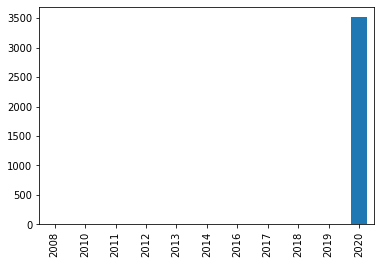

In [0]:
cv['Year']=cv.date_published.apply(lambda s: s.split('-')[0] if type(s)==str else 
                                          s.get('date').split('-')[0] )
cv=cv[~cv['Year'].isna()].reset_index(drop=True)
cv['Year']=cv['Year'].astype(int)
cv[cv['Year']>2007]['Year'].value_counts().sort_index().plot(kind='bar')

### Search for citations

In [0]:
if os.getcwd()=='/content':
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lens.org allows to search for a list of idintifiers ot length until 20

In [0]:
l=list(cv['scholarly_citations'].apply(pd.Series).stack().unique())
len(l)

452

In [0]:
cvc=pd.DataFrame()
rold=0
terms_max=20
lenl=len(l)
steps=list(range(0,lenl,terms_max))[1:]+[ lenl ]
for r in steps:
    ll=l[rold:r]
    rold=r
    #make lens query
    tmp=get_query(query_terms,lens_id=ll,url=url,token=token)
    cvc=cvc.append(tmp).reset_index(drop=True)
    cvc.to_json('covid_19_scholarly_citations.json')
    if os.getcwd()=='/content':
        !cp covid_19_scholarly_citations.json drive/My\ Drive
        
    time.sleep(5)
    #break    

In [0]:
cvc

,total,data,results
0,20,"{'lens_id': '003-127-464-982-370', 'created': ...",20
1,20,"{'lens_id': '012-011-397-538-967', 'created': ...",20
2,20,"{'lens_id': '014-541-219-035-444', 'created': ...",20
3,20,"{'lens_id': '015-517-208-703-589', 'created': ...",20
4,20,"{'lens_id': '018-684-021-973-690', 'created': ...",20
...,...,...,...
447,12,"{'lens_id': '110-036-168-210-398', 'created': ...",12
448,12,"{'lens_id': '165-124-194-843-143', 'created': ...",12
449,12,"{'lens_id': '192-133-947-684-196', 'created': ...",12
450,12,"{'lens_id': '194-137-793-241-923', 'created': ...",12


In [0]:
dfcvc=pd.DataFrame(list(cvc.data.values))

In [0]:
dfcvc.to_json('covid_19_scholarly_citations.json')

In [0]:
dfcvc.columns

Index(['lens_id', 'created', 'publication_type',
       'publication_supplementary_type', 'authors', 'title', 'languages',
       'references', 'fields_of_study', 'source_urls', 'abstract',
       'year_published', 'references_count', 'external_ids', 'source',
       'author_count', 'date_published', 'volume', 'issue', 'open_access',
       'start_page', 'end_page', 'keywords', 'mesh_terms', 'chemicals',
       'scholarly_citations_count', 'scholarly_citations', 'funding',
       'clinical_trials'],
      dtype='object')